<a href="https://colab.research.google.com/github/AxelPribadi/LLMProject/blob/main/LLMModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00


In [ ]:
# !pip install torch torch-xla

# LLM Project Model

## Import Libraries

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import torch
import transformers

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import evaluate # load_metric replaced with evaluate.load()

In [45]:
import shutil
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Data PreProcessing

In [5]:
# import data
# df = pd.read_csv('gdrive/MyDrive/DS Projects/AI_Human.csv')
df = pd.read_csv('sampled.csv')

print(df.shape)
df.head()

(3000, 2)


,text,generated
0,Technology has become an integral Part of our...,1.0
1,"Single plastic product, Such AG Straw, being, ...",1.0
2,The Opportunity to Graduate from Early: Benef...,1.0
3,Title: The Benefits and Drawbacks of Pairing Y...,1.0
4,"""It fink that animals should not be used in sc...",1.0


In [6]:
# convert "generated" data type float -> int
df["generated"] = df["generated"].astype(int)

# rename "generated" to "labels"
df = df.rename(columns={"generated": "labels"})

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3000 non-null   object
 1   labels  3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


In [8]:
print(df.labels.value_counts())
df.labels.value_counts(normalize=True) * 100

labels
1    1500
0    1500
Name: count, dtype: int64


,proportion
labels,
1,50.0
0,50.0


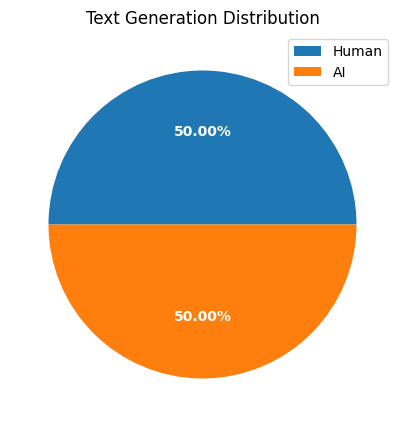

In [9]:
# plot a pie chart for data distribution
plt.figure(figsize=(5,5))

plt.pie([df["labels"].value_counts()[0], df["labels"].value_counts()[1]],
        autopct="%.2f%%",
        textprops={"color": "white", "fontweight":"bold"})

plt.legend(["Human", "AI"], loc="upper right")
plt.title("Text Generation Distribution")
plt.show()

In [10]:
df.iloc[0,0]

' Technology has become an integral Part of our daily lives, with almost everyone using it in some way. While it has brought many benefits, it has also had a significant impact on our social interactions and daily activities. In this essay, I will argue that technology has both Positive and negative effects on our lives.\n\nOn the Positive side, technology has made it easier for Google to stay connected with their loved ones, regardless of distance. Social media Platforms and messaging ages have made it Possible for Google to communicate with friends and family from all over the world. Additionally, technology has made it easier for Google to access information and knowledge, allowing them to learn and grow in new ways.\n\nHowever, there are also negative effects of technology that cannot be ignored. One of the most significant impacts is the way it has changed our social interactions. People now send more time on their devices than socializing with others, which can lead to feelings o

## Modelling

### Data Preparation

In [11]:
# convert dataset type
dataset = Dataset.from_pandas(df)
dataset

Dataset({
    features: ['text', 'labels'],
    num_rows: 3000
})

In [12]:
dataset[0]

{'text': ' Technology has become an integral Part of our daily lives, with almost everyone using it in some way. While it has brought many benefits, it has also had a significant impact on our social interactions and daily activities. In this essay, I will argue that technology has both Positive and negative effects on our lives.\n\nOn the Positive side, technology has made it easier for Google to stay connected with their loved ones, regardless of distance. Social media Platforms and messaging ages have made it Possible for Google to communicate with friends and family from all over the world. Additionally, technology has made it easier for Google to access information and knowledge, allowing them to learn and grow in new ways.\n\nHowever, there are also negative effects of technology that cannot be ignored. One of the most significant impacts is the way it has changed our social interactions. People now send more time on their devices than socializing with others, which can lead to f

In [13]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [15]:
tokenized_datasets

Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 3000
})

In [16]:
# # Save the dataset for quick access later

# # using pickle
# import pickle
# from google.colab import files

# with open("/content/gdrive/MyDrive/DS Projects/tokenized_datasets.pkl", 'wb') as f:
#     pickle.dump(tokenized_datasets, f)

# print('Object saved.')

# with open('/content/gdrive/MyDrive/DS Projects/tokenized_datasets.pkl', 'rb') as f:
#     tokenized_df = pickle.load(f)



# # using the datasets library
# tokenized_datasets.save_to_disk('/content/gdrive/MyDrive/DS Projects/tokenized_datasets')


In [17]:
# train test split
df_train_test_split = tokenized_datasets.train_test_split(test_size=0.4, seed=111)

df_train = df_train_test_split["train"]
df_test_val = df_train_test_split["test"]

df_test_val_split = df_test_val.train_test_split(test_size=0.5, seed=111)

df_test = df_test_val_split["test"]
df_val = df_test_val_split["train"]



In [18]:
df_train, df_test, df_val

(Dataset({
     features: ['text', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 1800
 }),
 Dataset({
     features: ['text', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 600
 }),
 Dataset({
     features: ['text', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 600
 }))

In [19]:
print(df_train.column_names)
print(df_test.column_names)
print(df_val.column_names)

['text', 'labels', 'input_ids', 'attention_mask']
['text', 'labels', 'input_ids', 'attention_mask']
['text', 'labels', 'input_ids', 'attention_mask']


### Hyperparameter Tuning

In [30]:
# set model metrics
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)

  accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
  precision = precision_metric.compute(predictions=predictions, references=labels)
  recall = recall_metric.compute(predictions=predictions, references=labels)
  f1_score = f1_metric.compute(predictions=predictions, references=labels)

  return {"eval_accuracy": accuracy["accuracy"],
          "eval_precision": precision["precision"],
          "eval_recall": recall["recall"],
          "eval_f1": f1_score["f1"]
          }


In [32]:
# set model parameters
training_args = TrainingArguments(output_dir="test_trainer_allmetrics",
                                  num_train_epochs=3,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  warmup_steps=100,
                                  weight_decay=0.01,
                                  learning_rate=2e-5,
                                  logging_dir='./logs_allmetrics',
                                  logging_steps=50,
                                  eval_strategy="epoch",
                                  save_strategy="epoch",
                                  save_total_limit=1,
                                  load_best_model_at_end=True,
                                  metric_for_best_model='eval_accuracy',
                                  greater_is_better=True
                                  )

# set up model
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=df_train,
                  eval_dataset=df_val,
                  compute_metrics=compute_metrics
)

### Model Training and Evaluation

In [33]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.014300,0.308645,0.938333,0.895349,0.996764,0.943338
2,0.034300,0.065230,0.986667,0.996700,0.977346,0.986928
3,0.010000,0.059543,0.988333,0.996711,0.980583,0.988581


TrainOutput(global_step=339, training_loss=0.01916894024089638, metrics={'train_runtime': 382.6716, 'train_samples_per_second': 14.111, 'train_steps_per_second': 0.886, 'total_flos': 715323952742400.0, 'train_loss': 0.01916894024089638, 'epoch': 3.0})

In [36]:
eval_results = trainer.evaluate(eval_dataset=df_val)
print("Validation Results:", eval_results)

Validation Results: {'eval_accuracy': 0.9883333333333333, 'eval_precision': 0.9967105263157895, 'eval_recall': 0.9805825242718447, 'eval_f1': 0.9885807504078304, 'eval_loss': 0.05954277142882347, 'eval_runtime': 12.324, 'eval_samples_per_second': 48.686, 'eval_steps_per_second': 3.083, 'epoch': 3.0}


In [34]:
test_results = trainer.evaluate(eval_dataset=df_test)
print("Test Results:", test_results)

Test Results: {'eval_accuracy': 0.9933333333333333, 'eval_precision': 0.9933110367892977, 'eval_recall': 0.9933110367892977, 'eval_f1': 0.9933110367892977, 'eval_loss': 0.028440220281481743, 'eval_runtime': 12.1704, 'eval_samples_per_second': 49.3, 'eval_steps_per_second': 3.122, 'epoch': 3.0}


In [37]:
checkpoint_path = "/content/test_trainer_allmetrics"

shutil.make_archive(checkpoint_path, 'zip', checkpoint_path)

'/content/test_trainer_allmetrics.zip'

In [41]:
print("Evaluation Metrics:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

Evaluation Metrics:
eval_accuracy: 0.9883
eval_precision: 0.9967
eval_recall: 0.9806
eval_f1: 0.9886
eval_loss: 0.0595
eval_runtime: 12.3240
eval_samples_per_second: 48.6860
eval_steps_per_second: 3.0830
epoch: 3.0000


In [42]:
print("Test Metrics:")
for key, value in test_results.items():
    print(f"{key}: {value:.4f}")

Test Metrics:
eval_accuracy: 0.9933
eval_precision: 0.9933
eval_recall: 0.9933
eval_f1: 0.9933
eval_loss: 0.0284
eval_runtime: 12.1704
eval_samples_per_second: 49.3000
eval_steps_per_second: 3.1220
epoch: 3.0000


### Predictions with Trainer

In [64]:
# sample1 (AI TEXT)
sample1 = """[Your Name]
[Your Address]
[City, State, ZIP Code]
[email Address]
[Phone Number]
[Date]

[Senator's Name]
[Senator's Address]
[City, State, ZIP Code]

Subject: Support for the electoral College

Dear Senator [Senator's Last Name],

I am writing to express my support for the electoral College in the election of the President of the United States. While there are arguments for both keeping the electoral College and changing to the election by popular vote, I firmly believe that the electoral College is a necessary component of our democratic system for several reasons.

Firstly, the electoral College ensures the certainty of the outcome. As mentioned in the text "In Defense of the electoral College" by Judge Richard A. Poster, a dispute over the outcome of a electoral College vote is less likely to occur compared to a dispute over the popular vote. The winning candidate's share of the electoral College generally exceeds their share of the popular vote, making it less likely for a tie or major discrepancies to occur.

Secondly, the electoral College ensures that the president elected has transregional appeal. This means that no single region has enough electoral votes to elect a president, thereby requiring candidates to campaign in various regions and appeal to a diverse range of voters. This is important as it prevents candidates with only regional appeal from being elected, ultimately benefiting all regions of the country and ensuring that the new president is truly representative of the whole nation.

Another advantage of the electoral College is that it focuses campaign efforts on swing states. As noted in the same text, candidates concentrate their campaigns on tossup states where the outcome is uncertain. This means that voters in swing states receive more attention, information, and consideration from the competing candidates, making them more thoughtful voters. Ultimately, the most thoughtful voters should have the power to decide the election.

Furthermore, the electoral College restores balance between large and small states. In "In Defense of the electoral College," Judge Poster explains that the electoral College gives some weight to large states, compensating for the apportionment of the Senate decreed in the Constitution. This ensures that candidates pay attention to both large and small states, as they are aware that every state matters in the electoral vote count.

Lastly, the electoral College avoids the need for runoff elections. In the event that no candidate receives a majority of the popular votes, the electoral College ensures that a clear winner is produced. This eliminates the complexities and challenges associated with runoff elections, making the presidential election process smoother and more decisive.

While critics argue that the electoral College may discourage voters in states with a predetermined outcome, it is important to note that voter turnout is not solely driven by the belief that a single vote may decide an election. According to "The Indefensible electoral College" by Bradford Plume, nearly half of the eligible American population voted in the 2012 election, despite knowing that their individual vote may not swing the national outcome. Voters participate in presidential elections to express their political preference and exercise their right to vote, regardless of whether their state's outcome is predictable or not.

In conclusion, the electoral College plays a vital role in our democratic process. It ensures the certainty of the outcome, promotes transregional appeal, focuses campaigns on swing states, restores balance among states, and prevents the need for runoff elections. While critics argue in favor of a popular vote, the electoral College provides numerous benefits and safeguards the interests of both large and small states. Therefore, I urge you to support the continuation of the electoral College in the election of the President of the United States.

Thank you for your time and consideration. I look forward to hearing about your stance on this matter and any actions you plan to take on behalf of your constituents.

Sincerely,

[Your Name]
"""


In [65]:
# sample2 (HUMAN TEXT)
sample2 = """Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.

In like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go. Article, "Paris bans driving due to smog," by Robert Duffer says, how Paris, after days of nearrecord pollution, enforced a partial driving ban to clear the air of the global city. It also says, how on Monday, motorist with evennumbered license plates were ordered to leave their cars at home or be fined a 22euro fine 31. The same order would be applied to oddnumbered plates the following day. Cars are the reason for polluting entire cities like Paris. This shows how bad cars can be because, of all the pollution that they can cause to an entire city.

Likewise, in the article, "Carfree day is spinning into a big hit in Bogota," by Andrew Selsky says, how programs that's set to spread to other countries, millions of Columbians hiked, biked, skated, or took the bus to work during a carfree day, leaving streets of this capital city eerily devoid of traffic jams. It was the third straight year cars have been banned with only buses and taxis permitted for the Day Without Cars in the capital city of 7 million. People like the idea of having carfree days because, it allows them to lesson the pollution that cars put out of their exhaust from people driving all the time. The article also tells how parks and sports centers have bustled throughout the city uneven, pitted sidewalks have been replaced by broad, smooth sidewalks rushhour restrictions have dramatically cut traffic and new restaurants and upscale shopping districts have cropped up. Having no cars has been good for the country of Columbia because, it has aloud them to repair things that have needed repairs for a long time, traffic jams have gone down, and restaurants and shopping districts have popped up, all due to the fact of having less cars around.

In conclusion, the use of less cars and having carfree days, have had a big impact on the environment of cities because, it is cutting down the air pollution that the cars have majorly polluted, it has aloud countries like Columbia to repair sidewalks, and cut down traffic jams. Limiting the use of cars would be a good thing for America. So we should limit the use of cars by maybe riding a bike, or maybe walking somewhere that isn't that far from you and doesn't need the use of a car to get you there. To me, limiting the use of cars might be a good thing to do.
"""

In [66]:
# sample3 (HUMAN TEXT)
sample3 = """"America's love affair with it's vehicles seems to be cooling" says Elisabeth rosenthal. To understand rosenthal's perspective, it is easier to suggest that America's car usage is decreasing slowly. This isn't necessarily bad in the sense that it has certain positive effects. The advantages of limiting car usage includes an increase in security and health, along with a decrease in pollution and dependence.

Firstly, when car usage is limited security and health is more likely to be guaranteed. The feeling of being secure is highly important to individuals everywhere. For example, many people in colombia used public transportation during a car free day "leaving the streets of this capital city ", according to Andrew Selsky, "eerily devoid of traffic jams". The complications that stem from traffic jams end with a feeling of confidence. The plan to get from point A to B was more simple just a second ago. This complication in your personal plans leads you to become stressed as a feeling of doubt overcomes all thoughts. If car usage was limited, there would be a control on how much traffic accumulates thus minimizing chance of stress. As Heidrun Walter states "when i had a car i was always tense. I'm much happier this way". not only does car usage minimize conditions detrimental to health, it also enlarges your capacity for exercise. The main purpose of the car is to get someone from one place to another. when an important job takes over your personal life, it becomes difficult to do things most enjoyed in life. limits on car usage forces you to stay in shape. According to Andrew Selsky "parks and sports centers also have bloomed throughout the city". Less cars means healthier and natural situations. With parks and sport centers becoming more efficient, it becomes easier to find a more physically active population. Overall, less usage on cars minimizes stress and increases health.

Secondly, limting car usage becomes beneficial to the environment. Now a days people have become annoyed with others who care so passionately about the environment. If you look behind their constant cries for action, there are solid facts. Yespollution is bad for the environment. Yes a bad envorment means unhealthy living. Yes cars are one of the main contributors to pollution in the environment. A pattern of less car usage, as Elisabeth Rosenthal states "will have beneficial implications for carbon emissions and the environment". The less use of cars, the less pollution in the environment. One must observe limiting car usage as an opportunity to create a cleaner world and better future. The effects of pollution in the environment is completley dangerous and we, the car users, are to blame.

Additionally, it would lower the dependence on cars. Many people today find that their car is so useful. While it has many features and is a form of transportation, many do not figure what they would do if they did not have such a possesion. The development of people and their interaction with technology has left a wide gap between historic, natural ways and what is thought of as modern society. Being dependent is not always good for individuals. As david goldberg says "all our development since world war II has been centered on the car, and that will have to change". Many people could disagree and wonder why it is necessary to change our ways especially if we are so highly devloped. If being developed means being dependent on a harmful machine, then it could not be effective devlopment. According to Elisabeth Rosenthal "cashstrapped americans could not afford new cars, and the unemployed were't going to work anyway". Many people can't have the precious luxury of private transportation in the first place. Those who have had it have become distant to a more natural society. Peope have become so use to having cars that they have become oblivious to the significant effects. With limits on car usage , these effcts could be controlled.

To conclude, the advantages of limiting car usage is an increase in health, along with a decrease in pollution, and less dependence on cars. limiting car usage is a positive way to enfore an organized and clean environment, and ensure health and security of those who live in it. This is one reason America can be reffered to as a succesful country. It is not that America has decreased use of vehicles, but the fact that they have done what is best for majority.
"""

In [67]:
# sample4 (AI TEXT)
sample4 = """In his essay "Self-Reliance", Ralph Waldo Emerson wrote, "The great man is he who in the midst of the crowd keeps with perfect sweetness the independence of solitude." This statement captures the essence of the idea of being alone in the world â€“ that is, one can be surrounded by people, yet remain independent and content despite the lack of connection with them.

Nevertheless, while Emerson's words might suggest that it is possible to do something meaningful without the help and support of others, this idea is unrealistic in practice. Human beings rely on each other for countless things - whether it is emotional support, advice, or practical assistance in achieving something. In this sense, going it alone is rarely a viable option, and as such, it is difficult to do something meaningful without the help and support of others.

At the same time, this does not mean that it is impossible to do something meaningful alone. In fact, there are many examples of individuals who have made significant contributions without any sort of supportive network. One could argue that learning to rely on oneself could be a meaningful achievement in its own right. Therefore, while it is true that living a life without the help and support of others is more difficult, it is not impossible. Ultimately, it is up to the individual to determine whether it is possible to do something meaningful without the help and support of others.
"""

In [68]:
# sample5 (AI TEXT)
sample5 = """The Development of Driverless Cars

The development of driverless cars presents both opportunities and challenges that require careful consideration. While these autonomous vehicles could potentially improve safety and mobility, their widespread adoption also raises valid privacy and ethical concerns. On balance, I believe the benefits of developing driverless car technology outweigh the risks, so long as proper precautions are taken to address issues of data security and how the vehicles should respond in emergency situations.

One of the primary advantages of self-driving cars highlighted in the article is improved traffic safety. Without human error in control, these vehicles could reduce or even eliminate accidents caused by distracted, drunk, or reckless driving. The sensors and computer systems would not suffer from human failings like fatigue or poor judgment calls. This could save thousands of lives each year from crash-related fatalities and injuries. Additionally, driverless cars could provide independence to those unable to drive themselves, such as the elderly or disabled. By expanding access to transportation, they may improve both individual freedom and economic participation.

At the same time, privacy issues arise from the vast amounts of data these vehicles would collect during operation. The article notes valid concerns about hackers accessing route history or other personal details from the cars' systems. There is also the challenging ethical question of how the computers should respond in situations where an unavoidable accident could hurt either passengers or pedestrians. Developers will need to implement robust security protocols and set guidelines for prioritizing safety in split-second decisions to justify public trust.

In conclusion, while driverless cars present both risks and benefits, their potential to save lives through removing human fallibility from the roads outweighs these concerns if the technology is developed and applied carefully and conscientiously. With prudent oversight and regulation addressing data protection as well as programming for ethical dilemmas, autonomous vehicles could significantly improve transportation for all. Overall their introduction seems not only inevitable but desirable for societal progress - if issues around privacy, accountability and emergency protocols receive due consideration.
"""


In [82]:
random_data = pd.DataFrame({
    "text": [sample1,sample2,sample3,sample4,sample5]
})

In [85]:
random_datasets = Dataset.from_pandas(random_data)

In [86]:
random_datasets

Dataset({
    features: ['text'],
    num_rows: 5
})

In [87]:
tokenized_random_dataset = random_datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

In [89]:
predictions = trainer.predict(tokenized_random_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

In [91]:
for text, label in zip(random_data["text"], predicted_labels):
    print(f"Predicted Label: {label}")

Predicted Label: 1
Predicted Label: 0
Predicted Label: 0
Predicted Label: 1
Predicted Label: 1


### Save, Load, and Predict with Fine-Tuned Model

In [93]:
# save model and tokenizer
model.save_pretrained("./local_model")
tokenizer.save_pretrained("./local_model")

('./local_model/tokenizer_config.json',
 './local_model/special_tokens_map.json',
 './local_model/vocab.txt',
 './local_model/added_tokens.json',
 './local_model/tokenizer.json')

In [94]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [96]:
# load model and tokenizer
loaded_model = AutoModelForSequenceClassification.from_pretrained('./local_model')
loaded_tokenizer = AutoTokenizer.from_pretrained('./local_model')

In [122]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loaded_model.to(device)
max_length = loaded_tokenizer.model_max_length

device

device(type='cuda')

In [126]:
# tokenize input
inputs = loaded_tokenizer(sample3, return_tensors='pt', max_length=max_length, truncation=True, padding='max_length').to(device)

In [127]:
# predict text
with torch.no_grad():
    outputs = loaded_model(**inputs)

# Extract logits and predicted class
logits = outputs.logits
predicted_class = logits.argmax().item()

print(f'Predicted class: {predicted_class}')

Predicted class: 0
